In [1]:
# git clone https://github.com/google/differential-privacy/tree/main
# cd differential-privacy/python
# python3.11 -m venv venv
# source venv/bin/activate
# python3 -m ensurepip
# python3 setup.py install
# pip3 install -r requirements.txt
# pip install notebook ipykernel
# ipython kernel install --user --name=myenv

import json
import glob
import pathlib
import numpy as np
import sys
sys.path.append("differential-privacy/python")
from dp_accounting.pld import privacy_loss_distribution

# plot
import matplotlib.pyplot as plt
import seaborn as sns

def compute_epsilon(n_epochs, epsilon, batch_size, delta=1e-5):
    n_iter_in_epoch = n_data // batch_size
    standard_deviation = 1
    sensitivity_for_sgd = 1
    if n_epochs == 0:
        return epsilon
    if epsilon == 0 or epsilon == float("inf"):
        gaussian_pld = privacy_loss_distribution.from_gaussian_mechanism(standard_deviation, sensitivity_for_sgd, sampling_prob=batch_size/n_data, value_discretization_interval=1e-3)
        gaussian_pld = gaussian_pld.self_compose(n_epochs * n_iter_in_epoch)
        return gaussian_pld.get_epsilon_for_delta(delta)
    else:
        sensitivity_for_global = 1
        laplace_pld = privacy_loss_distribution.from_laplace_mechanism(sensitivity_for_global/epsilon, sensitivity_for_global, value_discretization_interval=1e-3)
        gaussian_pld = privacy_loss_distribution.from_gaussian_mechanism(standard_deviation, sensitivity_for_global, sampling_prob=batch_size/n_data, value_discretization_interval=1e-3)
        gaussian_pld = gaussian_pld.self_compose(n_epochs * n_iter_in_epoch)
        composed_laplace_and_gaussian_pld = laplace_pld.compose(gaussian_pld)
        return composed_laplace_and_gaussian_pld.get_epsilon_for_delta(delta)    
    

def fetch_score_dpsgd(save_dir, metrics):
    save_dirs = glob.glob(str(data_dir / save_dir))
    epsilons = []
    scores = {metric: {} for metric in metrics}
    for save_dir in save_dirs:
        save_paths = glob.glob(str(pathlib.Path(save_dir) / "evaluated_model_*"))
        # sort path
        save_paths = sorted(save_paths, key=lambda x: int(x.split("/")[-1].split("_")[2].split(".")[0]))
        for save_path in save_paths:
            print("load", save_path)
            epoch = int(save_path.split("/")[-1].split("_")[2].split(".")[0])

            with open(pathlib.Path(save_path).parent / "params.json", "r") as f:
                setting = json.load(f)
            
            if "epsilon" not in setting:
                pre_training_epsilon = 0
            else:
                pre_training_epsilon = setting["epsilon"]

            if "batch_size" not in setting:
                batch_size = int(np.sqrt(counter))
                # print("batch_size", batch_size)
            else:
                batch_size = setting["batch_size"]

            # with open(save_path, "r") as f:
            #     result = json.load(f) 
            epsilon = compute_epsilon(epoch, pre_training_epsilon, batch_size)
            epsilons.append(epsilon)

            with open(save_path, "r") as f:
                result = json.load(f)

            for metric in metrics:
                if epsilon not in scores[metric]:
                    scores[metric][epsilon] = []
                scores[metric][epsilon].append(np.mean(result[metric]))
                # scores[epsilon].append(np.mean(result[metric]))

    epsilons = sorted(list(map(float, scores[metrics[0]].keys())))
    scores = {metric: [np.mean(scores[metric][epsilon]) for epsilon in epsilons] for metric in metrics}
    return epsilons, scores

def fetch_score(save_dir, metrics):
    save_dirs = glob.glob(str(data_dir / save_dir))
    scores = {metric: {} for metric in metrics}
    for path in save_dirs:
        save_path = pathlib.Path(path) / "evaluated_model_*"
        save_paths = glob.glob(str(save_path))
        for path in save_paths:
            print("load", path)
            epsilon = float(path.split("/")[-1].split("_")[2])
            with open(path, "r") as f:
                result = json.load(f)
            
            for metric in metrics:
                if epsilon not in scores[metric]:
                    scores[metric][epsilon] = []
                scores[metric][epsilon].append(np.mean(result[metric]))
    epsilons = sorted(list(map(float, scores[metrics[0]].keys())))
    scores = {metric: [np.mean(scores[metric][epsilon]) for epsilon in epsilons] for metric in metrics}
    return epsilons, scores

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.set_context("paper", font_scale=2.0)
markers = ["o", "v", "s", "D", "D"]
linestyles = ["-", "--", "-.", ":", ":"]


/data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_*
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_0.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_10.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_20.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_30.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_40.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_50.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_dim32_32_32_32_btch0_eps0.0_0/evaluated_model_60.pt_trun0_30.json
load /data/random/10000/bin30_seed0/baseline_dpTrue_pre0_d

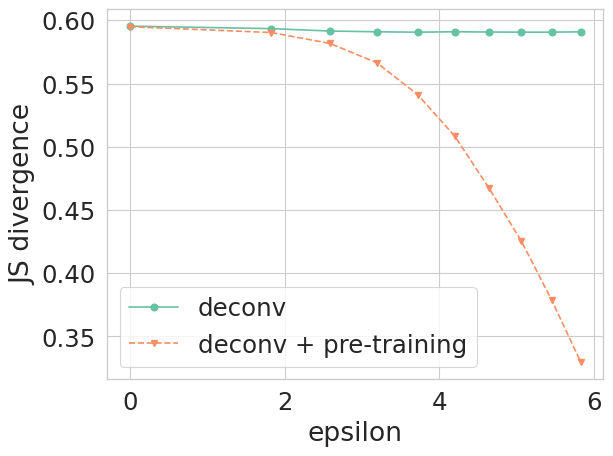

<Figure size 640x480 with 0 Axes>

In [2]:
data_dir = pathlib.Path("/data/random/10000/bin30_seed0/")
dim = 32

with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1
n_data = counter

save_names = [\
            # f"hiemrnet_dpTrue_meta0_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_*", \
            "/data/random/10000/bin30_seed0/hiemrnet_dpTrue_both0_dim32_32_32_32_btch0_trFalse_coFalse_eps0.0_*", \
            "/data/random/10000/bin30_seed0/hiemrnet_dpTrue_both10000_dim32_32_32_32_btch0_trFalse_coFalse_eps0.0_*", \
            "/data/random/10000/bin30_seed0/hiemrnet_dpTrue_both0_dim32_32_32_32_btch0_trTrue_coTrue_eps0.0_*", \
            "/data/random/10000/bin30_seed0/hiemrnet_dpTrue_both10000_dim32_32_32_32_btch0_trTrue_coTrue_eps0.0_*", \
            # f"hiemrnet_dpTrue_meta10000_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_*", \
            # f"hiemrnet_dpTrue_meta0_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trTrue_coFalse_mulFalse_test/evaluated_model_*", \
            # f"hiemrnet_dpTrue_meta10000_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trTrue_coFalse_mulFalse_test/evaluated_model_*", \
]

labels = [\
    "deconv", \
    "deconv + pre-training", \
    "deconv + multi-task", \
    "deconv + multi-task + pre-training" \
]


metrics = ["first_next_location_js"]
scoress = []
epsilonss = []

for save_name in save_names:
    print(save_name)
    epsilons, scores = fetch_score_dpsgd(save_name, metrics)
    scoress.append(scores)
    epsilonss.append(epsilons)

for metric in metrics:
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        plt.plot(epsilons, scores[metric], label=label, marker=marker, linestyle=linestyle)
    plt.xlabel("epsilon")
    plt.ylabel("JS divergence")
    plt.legend()
    # plt.savefig(f"priv_traj_gen/imgs/{dataset}_{metric}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

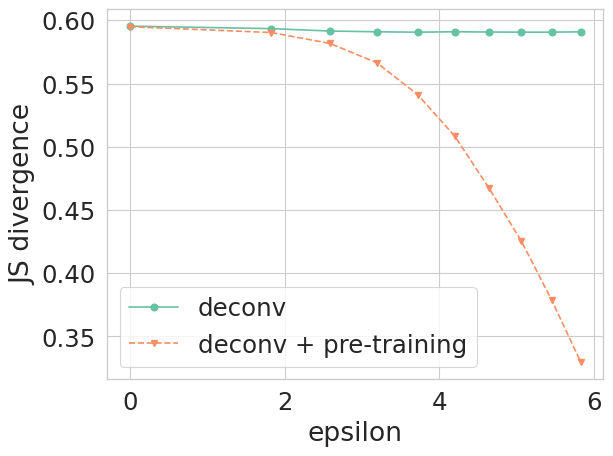

<Figure size 640x480 with 0 Axes>

In [4]:
for metric in metrics:
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        plt.plot(epsilons, scores[metric], label=label, marker=marker, linestyle=linestyle)
    plt.xlabel("epsilon")
    plt.ylabel("JS divergence")
    plt.legend()
    # plt.savefig(f"priv_traj_gen/imgs/{dataset}_{metric}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

In [7]:
data_dir = pathlib.Path("/data/geolife/0/200_30_bin62_seed0/")

dim = 32
save_names = [\
            f"baseline_dpTrue_meta0_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_*", \
            f"baseline_dpTrue_meta10000_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_*", \
            f"hiemrnet_dpTrue_meta0_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_*", \
            f"hiemrnet_dpTrue_meta10000_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_*", \
            f"hiemrnet_dpTrue_meta0_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trTrue_coFalse_mulFalse_test/evaluated_model_*", \
            f"hiemrnet_dpTrue_meta10000_dim{dim}_{dim}_{dim}_{dim}_btch0_cldepth_1000_trTrue_coTrue_mulFalse/evaluated_model_*", \
]

for save_name in save_names:
    epochs = []
    scores = []
    paths = glob.glob(str(data_dir / save_name))
    for path in paths:
        print(path)
        print(fetch_score_dpsgd(path, ["first_next_location_js"]))

labels = [\
    "baseline", \
    "p", \
    "d", \
    "d + p", \
    "d + m", \
    "d + p + m", \
]

# for epochs, scores, label in zip(epochss, scoress, labels):
for epochs, scores, label, marker, linestyle in zip(epochss, scoress, labels, markers, linestyles):
    # plt.plot(epochs, scores, label=label)
    plt.plot(epochs, scores, label=label, marker=marker, linestyle=linestyle)
plt.legend(fontsize=12)
plt.xlabel("epoch")
plt.ylabel("JS divergence")
plt.savefig("/priv_traj_gen/ablation_real.pdf", bbox_inches='tight')

/data/geolife/0/200_30_bin62_seed0/baseline_dpTrue_meta0_dim32_32_32_32_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_0.pt_trun0_62.json
([], {'first_next_location_js': []})
/data/geolife/0/200_30_bin62_seed0/baseline_dpTrue_meta0_dim32_32_32_32_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_10.pt_trun0_62.json
([], {'first_next_location_js': []})
/data/geolife/0/200_30_bin62_seed0/baseline_dpTrue_meta0_dim32_32_32_32_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_20.pt_trun0_62.json
([], {'first_next_location_js': []})
/data/geolife/0/200_30_bin62_seed0/baseline_dpTrue_meta0_dim32_32_32_32_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_30.pt_trun0_62.json
([], {'first_next_location_js': []})
/data/geolife/0/200_30_bin62_seed0/baseline_dpTrue_meta0_dim32_32_32_32_btch0_cldepth_1000_trFalse_coFalse_mulFalse_test/evaluated_model_40.pt_trun0_62.json
([], {'first_next_location_js': []})
/data/geolife/0/200_30_bin62_se

NameError: name 'epochss' is not defined

In [7]:
epochss = []
epsilonss = []
scoress = []

metrics = ["emp_next_jss", "destination_jss_eachdim", "target_jss", "distance_js"]
dataset = "peopleflow"
max_size = 20000
dim = 64

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/200_30_bin30_seed0/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1
n_data = counter

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/200_30_bin30_seed0/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1

dim = 64
save_dir = f"hiemrnet_dpTrue_pre10000_dim{dim}_{dim}_{dim}_{dim}_btch0_trTrue_coTrue_*"
epsilons, scores = fetch_score_dpsgd(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

dim = 64
save_dir = f"baseline_dpTrue_pre0_dim{dim}_{dim}_{dim}_{dim}_btch0_*"
epsilons, scores = fetch_score_dpsgd(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

fixed_bin = 32
save_dir = f"privtrace_{fixed_bin}_*"
epsilons, scores = fetch_score(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

k = 100
save_dir = f"clustering_{k}_*"
epsilons, scores = fetch_score(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_0.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_1.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_2.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_3.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_4.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_5.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_6.pt_trun0_

load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_13.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_14.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_15.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_16.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_17.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_18.pt_trun0_30.json
load /data/peopleflow/20000/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_2/evaluated_model_19.pt

emp_next_jss
0.3137113305371109
0.48904269650679766
0.5993082871238657
0.6773196675167263


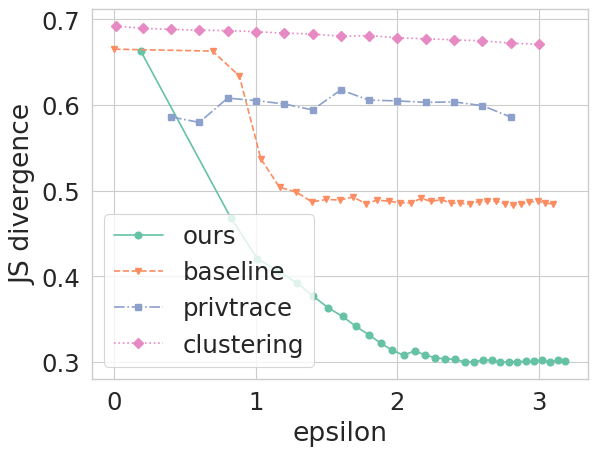

destination_jss_eachdim
6.167133713138863


10.08042655767401
26.254454407329764
23.43730060929536


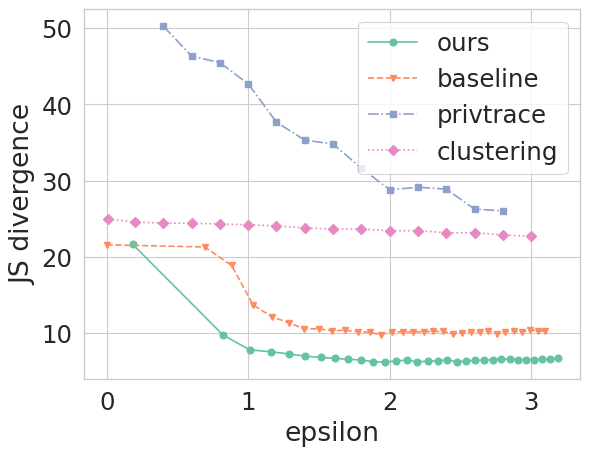

target_jss
0.5803781905929443
0.6702634843937055
0.6741358139088274
0.6747287219149972


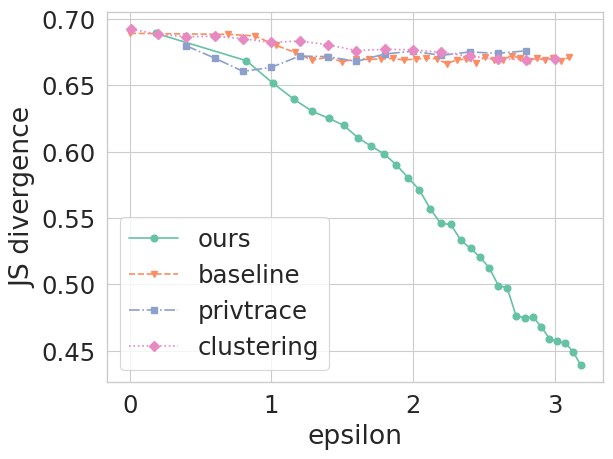

distance_js
0.06967929201496845
0.14331196338850435
0.03136689828111825
0.19515017059200415


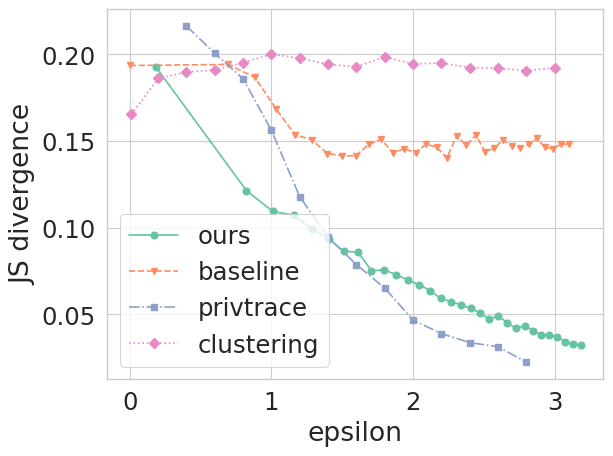

<Figure size 640x480 with 0 Axes>

In [8]:
labels = [\
    "ours", \
    "baseline", \
    "privtrace", \
    "clustering", \
]

for metric in metrics:
    print(metric)
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        print(scores[metric][np.argmin(np.abs(np.array(epsilonss[0]) - 2.0))])
        plt.plot(epsilons, scores[metric], label=label, marker=marker, linestyle=linestyle)
    plt.xlabel("epsilon")
    plt.ylabel("JS divergence")
    plt.legend()
    # plt.savefig(f"priv_traj_gen/imgs/{dataset}_{metric}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

In [5]:
epochss = []
epsilonss = []
scoress = []

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/200_30_bin30_seed0/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1
n_data = counter

metrics = ["emp_next_jss", "destination_jss_eachdim", "target_jss", "distance_js"]
dataset = "geolife"
max_size = 0
dim = 64

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/200_30_bin30_seed0/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1

dim = 64
save_dir = f"hiemrnet_dpTrue_pre10000_dim{dim}_{dim}_{dim}_{dim}_btch0_trTrue_coTrue_*"
epsilons, scores = fetch_score_dpsgd(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

dim = 64
save_dir = f"baseline_dpTrue_pre0_dim{dim}_{dim}_{dim}_{dim}_btch0_*"
epsilons, scores = fetch_score_dpsgd(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

fixed_bin = 32
save_dir = f"privtrace_{fixed_bin}_*"
epsilons, scores = fetch_score(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

k = 100
save_dir = f"clustering_{k}_*"
epsilons, scores = fetch_score(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_0.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_1.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_2.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_3.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_4.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_5.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/hiemrnet_dpTrue_pre10000_dim64_64_64_64_btch0_trTrue_coTrue_0/evaluated_model_6.pt_trun0_30.json
load /data/geolife/0/200_30_bin30_seed0/h

emp_next_jss
0.2016350851019772
0.4008108369042563
0.2387186590114425
0.4185976040758746


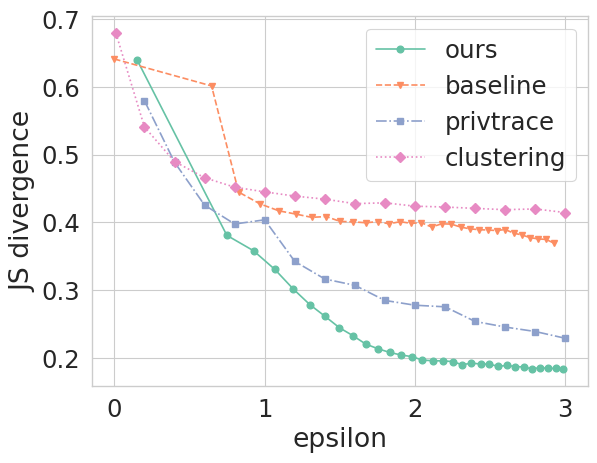

destination_jss_eachdim
5.772681592286969
6.773166393423826
13.143863484293579
9.333386041407092


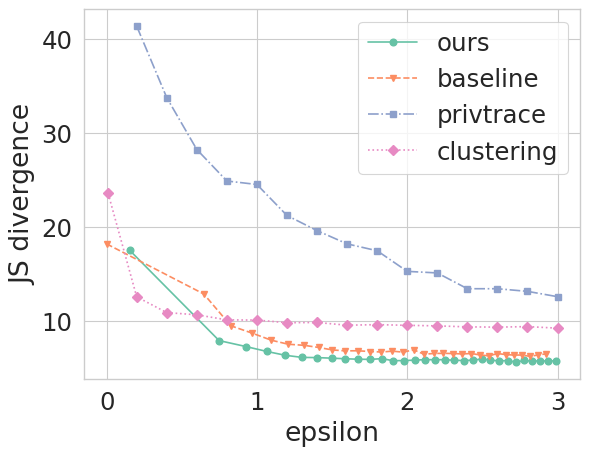

target_jss
0.1889962106112747
0.4012776775976129
0.2515095038519039
0.4333626742936949


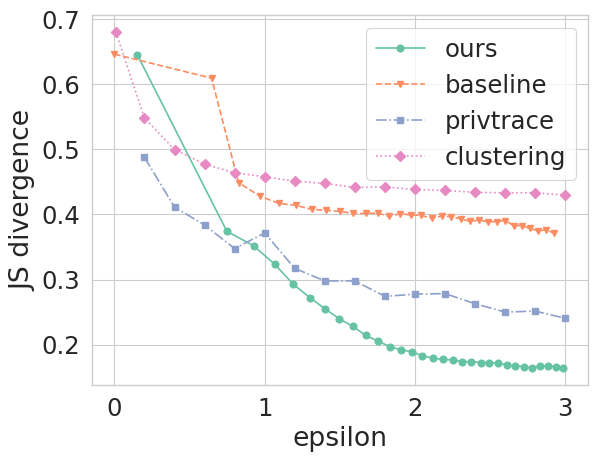

distance_js
0.016856773378972494
0.025947212656058947
0.048776756376031564
0.02016270207711785


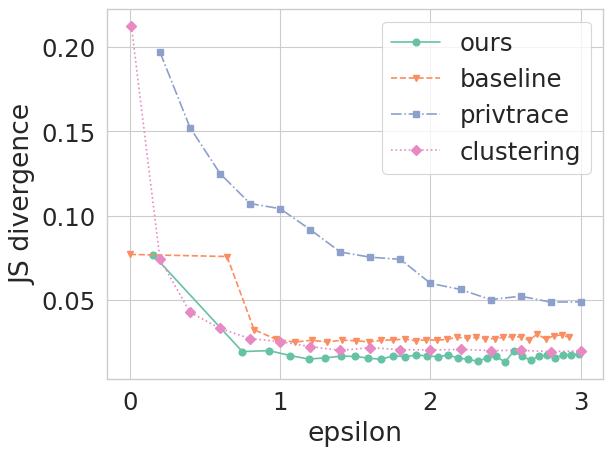

<Figure size 640x480 with 0 Axes>

In [ ]:
for metric in metrics:
    print(metric)
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        print(scores[metric][np.argmin(np.abs(np.array(epsilonss[0]) - 2.0))])
        plt.plot(epsilons, scores[metric], label=label, marker=marker, linestyle=linestyle)
    plt.xlabel("epsilon")
    plt.ylabel("JS divergence")
    plt.legend()
    # plt.savefig(f"priv_traj_gen/imgs/{dataset}_{metric}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

In [9]:


scoress = []
epsilonss = []

dataset = "chengdu"
max_size = 10000
data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/bin30_seed0/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1

n_data = counter

metrics = ["route_jss_eachdim", "target_jss"]

dim = 32
save_dir = f"hiemrnet_dpTrue_pre10000_dim{dim}_{dim}_{dim}_{dim}_btch0_trTrue_coTrue_*"
epsilons, scores = fetch_score_dpsgd(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

save_dir = "/data/chengdu/10000/bin30_seed0/mtnet_dpTrue_*"
epsilons, scores = fetch_score_dpsgd(save_dir, metrics)
scoress.append(scores)
epsilonss.append(epsilons)

load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_0.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_1.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_2.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_3.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_4.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_5.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_dim32_32_32_32_btch0_trTrue_coTrue_0/evaluated_model_6.pt_trun0_30.json
load /data/chengdu/10000/bin30_seed0/hiemrnet_dpTrue_pre10000_

route_jss_eachdim
5.322486826668622
7.521970452710354


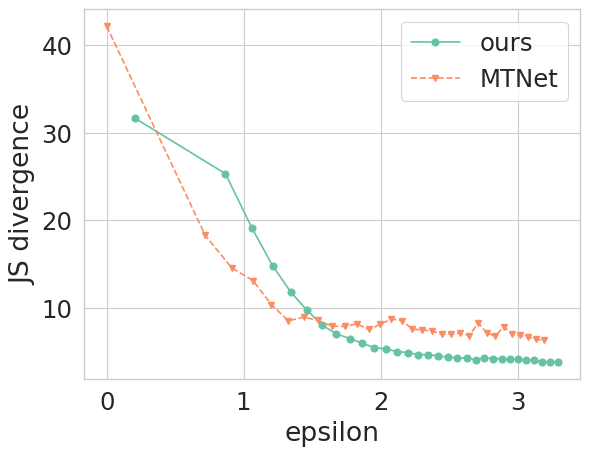

target_jss
0.24548764040479337
0.2840412554477378


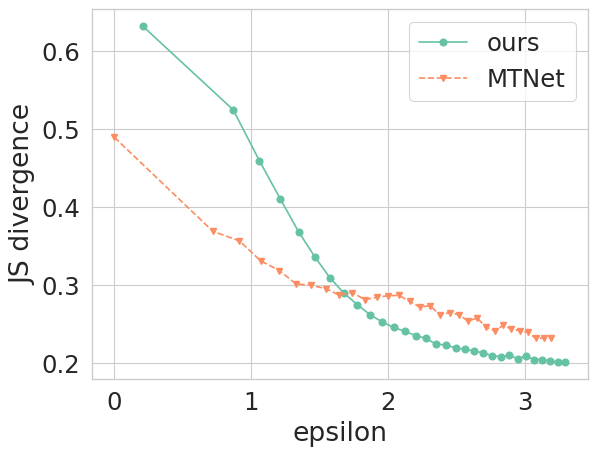

<Figure size 640x480 with 0 Axes>

In [10]:
labels = [\
    "ours", \
    "MTNet"
]

for metric in metrics:
    print(metric)
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        print(scores[metric][np.argmin(np.abs(np.array(epsilonss[0]) - 2.0))])
        plt.plot(epsilons, scores[metric], label=label, marker=marker, linestyle=linestyle)
    plt.xlabel("epsilon")
    plt.ylabel("JS divergence")
    plt.legend()
    plt.savefig(f"priv_traj_gen/imgs/{dataset}_{metric}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_*
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_0.pt_trun0_30.json
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_1.pt_trun0_30.json
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_2.pt_trun0_30.json
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_3.pt_trun0_30.json
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_4.pt_trun0_30.json
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_5.pt_trun0_30.json
load /data/peopleflow/10000/200_30_bin30_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_6.pt_

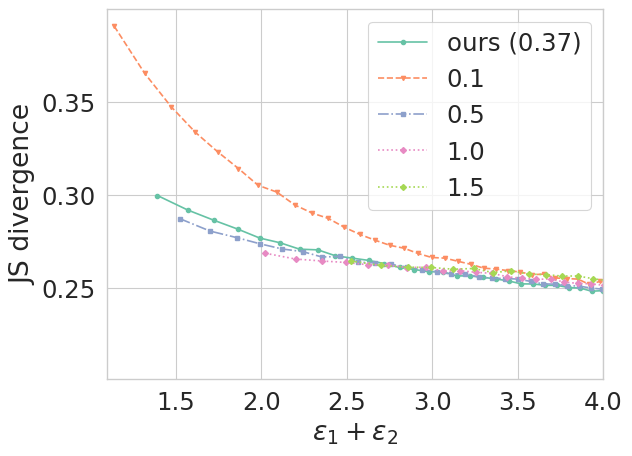

<Figure size 640x480 with 0 Axes>

In [11]:
from name_config import make_save_name, make_model_name
import pathlib

scoress = []
epsilonss = []

dataset = "peopleflow"
max_size = 10000
n_bins = 30
save_name = make_save_name(dataset, n_bins, 30/60, 200, 0)

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/{save_name}/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1
n_data = counter

metrics = ["first_next_location_js"]

# pre_epsilons = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
pre_epsilons = [0.0, 0.1, 0.5, 1.0, 1.5]
# pre_epsilons = [0.0]

dim = 64

for pre_epsilon in pre_epsilons:

    model_name = f"baseline_dpTrue_pre10000_dim{dim}_{dim}_{dim}_{dim}_btch0_eps{pre_epsilon}_*"
    print(model_name)
    epsilons, scores = fetch_score_dpsgd(model_name, metrics)
    epsilonss.append(epsilons)
    scoress.append(scores)


labels = [f"ours ({epsilonss[0][0]:.2f})"] + pre_epsilons[1:]

for metric in metrics:
    print(metric)
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        # print(scores[metric][np.argmin(np.abs(np.array(epsilonss[0]) - 2.0))])
        # plt.plot(epsilons[2:], gaussian_filter1d(replace_with_previous_if_increased(scores[metric]), sigma=sigma)[2:], label=label, marker=marker, linestyle=linestyle, markersize=3)
        plt.plot(epsilons[2:], scores[metric][2:], label=label, marker=marker, linestyle=linestyle, markersize=3)
    plt.xlabel("$\epsilon_1+\epsilon_2$")
    plt.xlim(1.1, 4.0)
    plt.ylabel("JS divergence")
    plt.legend()
    plt.savefig(f"priv_traj_gen/imgs/budget_alloc_{n_bins}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_*
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_0.pt_trun0_62.json
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_1.pt_trun0_62.json
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_2.pt_trun0_62.json
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_3.pt_trun0_62.json
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_4.pt_trun0_62.json
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_5.pt_trun0_62.json
load /data/peopleflow/10000/200_30_bin62_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_6.pt_

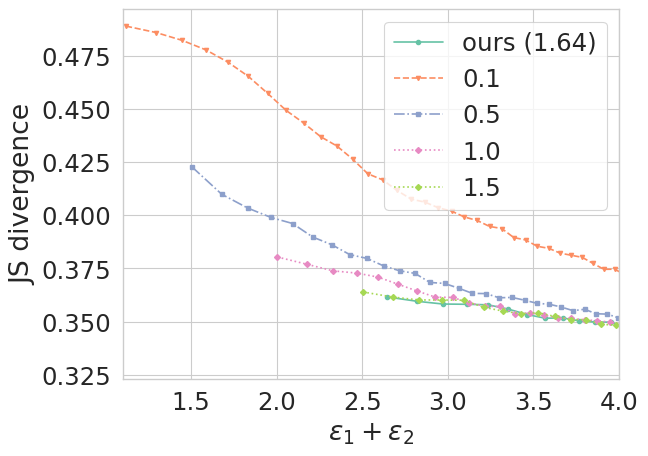

<Figure size 640x480 with 0 Axes>

In [12]:
from name_config import make_save_name, make_model_name
import pathlib

scoress = []
epsilonss = []

dataset = "peopleflow"
max_size = 10000
n_bins = 62
save_name = make_save_name(dataset, n_bins, 30/60, 200, 0)

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/{save_name}/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1
n_data = counter

metrics = ["first_next_location_js"]

# pre_epsilons = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
pre_epsilons = [0.0, 0.1, 0.5, 1.0, 1.5]
# pre_epsilons = [0.0]

dim = 64

for pre_epsilon in pre_epsilons:

    model_name = f"baseline_dpTrue_pre10000_dim{dim}_{dim}_{dim}_{dim}_btch0_eps{pre_epsilon}_*"
    print(model_name)
    epsilons, scores = fetch_score_dpsgd(model_name, metrics)
    epsilonss.append(epsilons)
    scoress.append(scores)


labels = [f"ours ({epsilonss[0][0]:.2f})"] + pre_epsilons[1:]

for metric in metrics:
    print(metric)
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        # print(scores[metric][np.argmin(np.abs(np.array(epsilonss[0]) - 2.0))])
        # plt.plot(epsilons[2:], gaussian_filter1d(replace_with_previous_if_increased(scores[metric]), sigma=sigma)[2:], label=label, marker=marker, linestyle=linestyle, markersize=3)
        plt.plot(epsilons[2:], scores[metric][2:], label=label, marker=marker, linestyle=linestyle, markersize=3)
    plt.xlabel("$\epsilon_1+\epsilon_2$")
    plt.xlim(1.1, 4.0)
    plt.ylabel("JS divergence")
    plt.legend()
    plt.savefig(f"priv_traj_gen/imgs/budget_alloc_{n_bins}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_*
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_0.pt_trun0_14.json
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_1.pt_trun0_14.json
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_2.pt_trun0_14.json
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_3.pt_trun0_14.json
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_4.pt_trun0_14.json
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_5.pt_trun0_14.json
load /data/peopleflow/10000/200_30_bin14_seed0/baseline_dpTrue_pre10000_dim64_64_64_64_btch0_eps0.0_0/evaluated_model_6.pt_

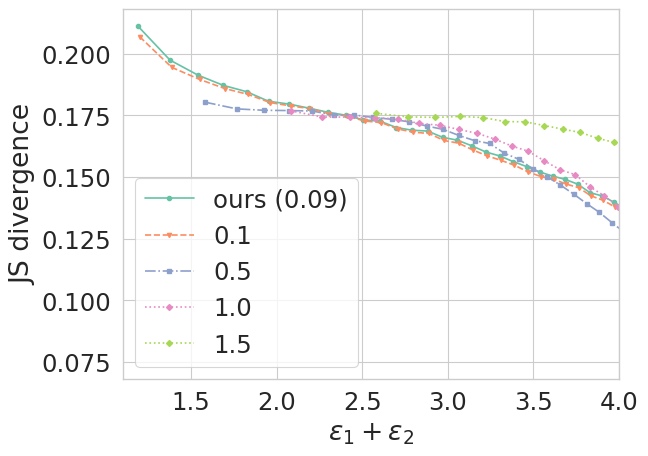

<Figure size 640x480 with 0 Axes>

In [13]:
from name_config import make_save_name, make_model_name
import pathlib

scoress = []
epsilonss = []

dataset = "peopleflow"
max_size = 10000
n_bins = 14
save_name = make_save_name(dataset, n_bins, 30/60, 200, 0)

data_dir = pathlib.Path(f"/data/{dataset}/{max_size}/{save_name}/")
with open(data_dir / "training_data.csv", "r") as f:
    counter = 0
    for line in f:
        counter += 1
n_data = counter

metrics = ["first_next_location_js"]

# pre_epsilons = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
pre_epsilons = [0.0, 0.1, 0.5, 1.0, 1.5]
# pre_epsilons = [0.0]

dim = 64

for pre_epsilon in pre_epsilons:

    model_name = f"baseline_dpTrue_pre10000_dim{dim}_{dim}_{dim}_{dim}_btch0_eps{pre_epsilon}_*"
    print(model_name)
    epsilons, scores = fetch_score_dpsgd(model_name, metrics)
    epsilonss.append(epsilons)
    scoress.append(scores)


labels = [f"ours ({epsilonss[0][0]:.2f})"] + pre_epsilons[1:]

for metric in metrics:
    print(metric)
    for epsilons, scores, label, marker, linestyle in zip(epsilonss, scoress, labels, markers, linestyles):
        # print(scores[metric][np.argmin(np.abs(np.array(epsilonss[0]) - 2.0))])
        # plt.plot(epsilons[2:], gaussian_filter1d(replace_with_previous_if_increased(scores[metric]), sigma=sigma)[2:], label=label, marker=marker, linestyle=linestyle, markersize=3)
        plt.plot(epsilons[2:], scores[metric][2:], label=label, marker=marker, linestyle=linestyle, markersize=3)
    plt.xlabel("$\epsilon_1+\epsilon_2$")
    plt.xlim(1.1, 4.0)
    plt.ylabel("JS divergence")
    plt.legend()
    plt.savefig(f"priv_traj_gen/imgs/budget_alloc_{n_bins}.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()